# Data collection and model annotation
<br>
<div align='center'><img src="https://raw.githubusercontent.com/vporubsky/tellurium-libroadrunner-tutorial/master/data_aggregation_logo.png" width = "50%" style="padding: 0px"></div>
<br>
<div align='center' style='font-size:100%'>
Veronica L. Porubsky, BS
<div align='center' style='font-size:100%'>Sauro Lab PhD Student, Department of Bioengineering<br>
Head of Outreach, <a href="https://reproduciblebiomodels.org/dissemination-and-training/seminar/">Center for Reproducible Biomedical Modeling</a><br>
University of Washington, Seattle, WA USA
</div>
<hr>

## TOC
* [What is data collection?](#data-collection)
* [What databases are useful for biochemical network modeling?](#databases)
* [What is metadata and how much should we collect?](#metadata)
* [Packages and constants](#packages-constants)
* [Importing data programmatically with bioservices](#import-with-bioservices)
* [Importing data programmatically with KEGG and bioservices](#import-with-KEGG)
* [Importing a kinetic constant from SABIO-RK using requests](#kinetic-constant-import)
* [Importing metadata programmatically with ChEBI](#collection-with-chebi)
* [What is model annotation and why do we do it?](#model-annotation)
* [Adding annotations to the repressilator model with Antimony](#repressilator-annotations-antimony)
* [Adding annotations to the repressilator model with sbmlutils](#repressilator-annotations-sbmlutils)
* [Exercises](#exercises)

# What is data collection? <a class="anchor" id="data-collection"></a>

The collection of data from multiple experiments, scientific papers, and online data sources is necessary
to fully-inform your model.

<br>
Typically, you will need to curate your collected data to ensure the quality of measurements is acceptable to include
in your model. This my involve excluding data from dissimilar species or environmental conditions than
your model system.


# What databases are useful for biochemical network modeling? <a class="anchor" id="databases"></a>


<ul>
  <li>SABIO-RK: biochemical reaction kinetics database</li>
     <ul class="square">
      <li>Describes chemical reactions and kinetics</li>
      <li>Contains information about participants and modifiers in reactions</li>
      <li>Metabolic and signaling network reactions</li>
     </ul>
  <li>BRENDA: the comprehensive enzyme information system</li>
     <ul class="square">
      <li>Enzyme information classified by the biochemical reaction it catalyzes</li>
      <li>Kinetic information about substrates and products is available</li> 
     </ul>
  <li>ChEBI: dictionary of "small" chemical compounds</li>
  <li>KEGG: collection of pathway/genome/diesease/drug databases</li>
  <li>BioCYC: collection of pathway/genome databases</li>
       <ul class="square">
      <li>Search for genes, proteins, metabolites or pathways, and the occurence of your term will be located in multiple databases</li> 
     </ul>
  <li>BioModels Database: repository of mathematical models of biological systems</li>
      <ul class="square">
      <li> *Will be covered in more detail later in the course</li> 
     </ul>
</ul>

<a href="https://www.sciencedirect.com/science/article/abs/pii/S0958166917301428?via%3Dihub">Appendix A of Goldberg et al. (2018)</a> provides a useful and more comprehensive list of data sources containing intracellular biochemical data. 


# What is metadata and how much should we collect? <a class="anchor" id="metadata"></a>

<ul>
  <li>Metadata: data that describes biochemical data</li>
  <li>Collect information about:</li>
     <ul class="square">
      <li>Units</li>
      <li>Estimates of measurement accuracy</li>
      <li>Annotations</li>
      <li>Ontology terms defining the annotations</li>
      <li>etc.</li>
     </ul>
  <li>Collect provenance data:</li>
     <ul class="square">
      <li>Lab which generated the data</li>
      <li>Experimental conditions</li>
      <li>Protocol used to generate the data</li>
      <li>Paper which reported the measurement</li>
      <li>etc.</li>
</ul>

# Packages and constants <a class="anchor" id="packages-constants"></a>

There are some package errors with this notebook - therefore there may be a lot of output in this section indicating warnings. This is being addressed by the instructors.

In [29]:
!pip install -q tellurium
!pip install -q bioservices
!pip install -q sbmlutils
!pip install -q pandas==1.1.0


import tellurium as te # Python-based modeling environment for kinetic models
from bioservices import * # Package for programmatically querying databases
import requests # Package to access information from a webpage
import io
import pandas as pd
from sbmlutils.metadata.annotator import ModelAnnotator, annotate_sbml # Use to annotate SBML
from pathlib import Path # Used for sbmlutils annotation functionality
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sbmlutils 0.4.12 requires pandas>=1.2.1, but you have pandas 1.1.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.


# Importing data programmatically with bioservices <a class="anchor" id="import-with-bioservices"></a>

<br>
Bioservices is a Python package that will allow you to programmatically access many Bioinformatics Web Services that we
discussed, including KEGG, the PDB, and ChEBI.

<br>
<br>
This allows you to query - or search for - quantities and identifiers that are of use in your modeling workflow. You
could import a kinetic rate constant and set the value of that constant in your model without having to manually
search the database online, copy, and paste the value in (which can result in human error).

# Importing data programmatically with KEGG and bioservices <a class="anchor" id="import-with-KEGG"></a>

In [30]:
# Select database
database = KEGG() # Kyoto Encyclopedia of Genes and Genomes

# Retrieve a KEGG entry for the tetR gene
tetR_query = database.get("K18476")

# Build a dictionary to parse query
tetR_dict = database.parse(tetR_query)

# Show information about the query
print(tetR_dict['NAME'])
print(tetR_dict['DEFINITION'])


['tetR']
TetR/AcrR family transcriptional regulator, tetracycline repressor protein


# Importing a kinetic constant from SABIO-RK using requests <a class="anchor" id="kinetic-constant-import"></a>

Another method to query some databases like SABIO-RK is to use the Python package, requests. This appraoch
is a bit more challenging, but the goal is to replicate the sort of search you would perform by looking up
a quantity in your web browser.

In [31]:
# Data curation for the formation of spike glycoprotein RBD-SD1-ACE2 complex in SARS-CoV-2 coronavirus.
# Imports the kinetic constant corresponding to this reaction from SABIO-RK

QUERY_URL = 'http://sabiork.h-its.org/sabioRestWebServices/kineticlawsExportTsv'

# Specify search fields and search terms
query_dict = {"Organism":'"SARS coronavirus"', "Product":'"Spike glycoprotein RBD-SD1-ACE2 complex"'}
query_string = ' AND '.join(['%s:%s' % (k,v) for k,v in query_dict.items()])

# Specify output fields and send request
query = {'fields[]':['EntryID', 'Organism', 'UniprotID', 'Parameter'], 'q':query_string}

# Now we make a request and get a response, or we return the webpage for our search/ query
response = requests.post(QUERY_URL, params = query)
response.raise_for_status()

# Print query results
print('\nThe results of SABIO-RK query for the formation of spike glycoprotein RBD-SD1-ACE2 complex in SARS coronavirus:\n')
response_string = response.text
data = io.StringIO(response_string) # Generates a csv file from the response string
dataframe = pd.read_csv(data, sep="\t") # Creates a dataframe from the response .csv data
print(dataframe) # Prints the dataframe so that we can see its contents

# Determine if there our query has information about the rate constant for this reaction
parameter_types = list(dataframe['parameter.type'])
# If we find the rate constant in the list of parameter_types,
# we will store it in a variable, complex_formation_rate_constant
if 'rate const.' in parameter_types:
    complex_formation_rate_constant = list(dataframe['parameter.startValue'])[parameter_types.index('rate const.')]
    complex_formation_rate_constant_units = list(dataframe['parameter.unit'])[parameter_types.index('rate const.')]

print(f"\nThe formation of the spike glycoprotein RBD-SD1-ACE2 complex occurs at a rate of {complex_formation_rate_constant :.3f} {complex_formation_rate_constant_units}.")



The results of SABIO-RK query for the formation of spike glycoprotein RBD-SD1-ACE2 complex in SARS coronavirus:

   EntryID          Organism  ... parameter.standardDeviation parameter.unit
0    66773  SARS coronavirus  ...                           -  M^(-1)*s^(-1)
1    66773  SARS coronavirus  ...                           -              M
2    66773  SARS coronavirus  ...                           -              M
3    66773  SARS coronavirus  ...                           -         s^(-1)
4    66773  SARS coronavirus  ...                           -              -

[5 rows x 9 columns]

The formation of the spike glycoprotein RBD-SD1-ACE2 complex occurs at a rate of 0.112 s^(-1).


In [32]:
# We can use this information in a model of spike glycoprotein complex formation with the ACE2 receptor
# We will write an Antimony string for this process -- note that the model may not be biologically plausible
# Assume bi-molecular mass-action rate law: v = k*[A][B]

spike_protein_binding_str = """
model spike_glycoprotein_ACE2_complex_formation

    // Species
    species ACE2, spike_glycoprotein_RBD_SD1, ACE2_spike_complex;


    // Reactions
    complex_formation: ACE2 + spike_glycoprotein_RBD_SD1 -> ACE2_spike_complex; k*ACE2*spike_glycoprotein_RBD_SD1;


    // Initial conditions
    ACE2 = 10.0;                         # assign ACE2 receptor initial conditions
    spike_glycoprotein_RBD_SD1 = 10.0;   # assign spike_glycoprotein_RBD_SD1 initial conditions

    // Parameter values
    k = 1.0;                             # assign constant values to the rate constant for the reaction
end
"""


# Test the simulation with the rate constant curated from SABIO-RK
spike_protein_binding = te.loada(spike_protein_binding_str)
spike_protein_binding.k = complex_formation_rate_constant
simulation_result = spike_protein_binding.simulate(0, 10, 100)


print(f"The rate constant used in the model for this reaction is: {spike_protein_binding.k}")

The rate constant used in the model for this reaction is: 0.11199999999999999


# Importing metadata programmatically with ChEBI <a class="anchor" id="collection-with-chebi"></a>

In [33]:
# Seach for metadata including the definition and chemical formula
# Select database
database = ChEBI() # Chemical entities of biological interest

# Retrieve a ChEBI entry for D-fructose 1,6-bisphosphate
query = database.getCompleteEntity("CHEBI:78682")

print(f'Definition: {query.definition}')
print(f'ID: {query.chebiId}')


Definition: A ketohexose bisphosphate that is D-fructose substituted by phosphate groups at positions 1 and 6. It is an intermediate in the glycolysis metabolic pathway.
ID: CHEBI:78682


# What is model annotation and why do we do it?  <a class="anchor" id="model-annotation"></a>

Annotation of a model is the process of adding metadata to a model description to identify components of the model with
specificity. The models we have used so far have been simplistic representations of comon reactions,
but if we start to construct a model of a true biological system, we will want to name our model components
using standard names that others can understand. We also want to be transparent about where the data
that informed our model originated.

# Adding annotations to the repressilator model with Antimony <a class="anchor" id="repressilator-annotations-antimony"></a>

We can add simple annotations directly to our Antimony string when we write our model.

In [34]:
repressilator_str = """
# Species:
species M1, P3, P1, M2, P2, M3;

# Reactions:
J0:  -> M1; a_m1*(Kr_P3^n1/(Kr_P3^n1 + P3^n1)) + leak1;
J1: M1 -> ; d_m1*M1;
J2:  -> P1; a_p1*M1;
J3: P1 -> ; d_p1*P1;
J4:  -> M2; a_m2*(Kr_P1^n2/(Kr_P1^n2 + P1^n2)) + leak2;
J5: M2 -> ; d_m2*M2;
J6:  -> P2; a_p2*M2;
J7: P2 -> ; d_p2*P2;
J8:  -> M3; a_m3*(Kr_P2^n3/(Kr_P2^n3 + P2^n3)) + leak3;
J9: M3 -> ; d_m3*M3;
J10:  -> P3; a_p3*M3;
J11: P3 -> ; d_p3*P3;

# Species initializations:
M1 = 0.604016261711246;
P3 = 1.10433330559171;
P1 = 7.94746428021418;
M2 = 2.16464969760648;
P2 = 3.55413750091507;
M3 = 2.20471854765531;

# Variable initializations:
a_m1 = 1.13504504342841;
Kr_P3 = 0.537411795656332;
n1 = 7.75907326833983;
leak1 = 2.59839004225795e-07;
d_m1 = 0.360168301619141;
a_p1 = 5.91755684808254;
d_p1 = 1.11075218613419;
a_m2 = 2.57306185467814;
Kr_P1 = 0.190085253528206;
n2 = 6.89140262856765;
leak2 = 1.51282707494481e-06;
d_m2 = 1.05773721506759;
a_p2 = 8.35628834784826;
d_p2 = 0.520562081730298;
a_m3 = 0.417889543691157;
Kr_P2 = 2.71031378955001;
n3 = 0.44365980532785;
leak3 = 3.63586125130783e-11;
d_m3 = 0.805873530762994;
a_p3 = 4.61276807677109;
d_p3 = 1.54954108126666;


// Annotations:
# Decay constants
d_m1.sboTerm = SBO:0000356
d_m2.sboTerm = SBO:0000356
d_m3.sboTerm = SBO:0000356

# Hill coefficients
n1.sboTerm = SBO:0000190
n2.sboTerm = SBO:0000190
n3.sboTerm = SBO:0000190

# Protein identities
P1 identity "http://identifiers.org/uniprot/P04483"
P2 identity "http://identifiers.org/uniprot/P03034"
P3 identity "http://identifiers.org/uniprot/P03023"
"""


# Adding annotations to the repressilator model with sbmlutils <a class="anchor" id="repressilator-annotations-sbmlutils"></a>

An alternative option for annotation in Python is to use sbmlutils, which provides rapid annotation when we have our
annotations arranged in a tabular format. This might be easier to organize while you are building your model,
and annotations can be imported and written to the SBML file after you have constructed your model.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sbmlutils 0.4.12 requires matplotlib>=3.3.3, but you have matplotlib 3.1.3 which is incompatible.
sbmlutils 0.4.12 requires pandas>=1.2.1, but you have pandas 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


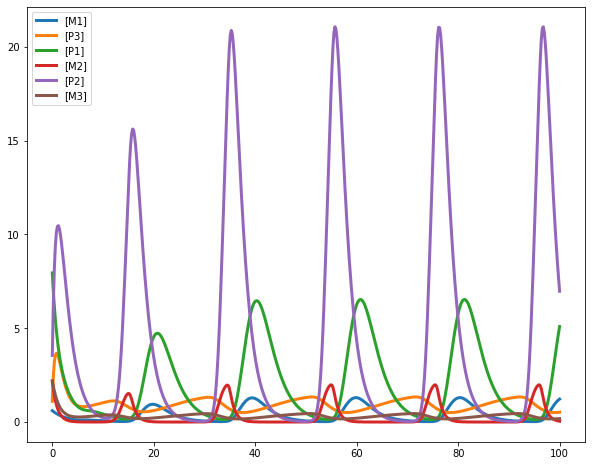

In [35]:
# Ensure package versions are compatible
!pip install -q matplotlib==3.1.3

# Load the repressilator model
repressilator = te.loada(repressilator_str)

# Save the repressilator model in the SBML format to be used for annotation with sbmlutils
te.saveToFile('repressilator_sbml.xml', repressilator.getCurrentSBML())

# Simulate the repressilator model
repressilator.simulate(0, 100, 500)
repressilator.plot(figsize = (10, 8), linewidth = 3)


In [ ]:
# Read and print the annotation file, stored as an .csv file on GitHub
annotations_url = "https://raw.githubusercontent.com/sys-bio/network-modeling-summer-school-2021/main/annotations/repressilator_annotations.csv"

# The Model Annotator class can read in various file formats - here we read in a .csv file
repressilator_annotations = ModelAnnotator.read_annotations_df(file_path=annotations_url, file_format = "csv")

# repressilator_annotations contains a dataframe, we can print this to see what is in our .csv file
print(repressilator_annotations.to_markdown())

# save the repressilator_annotations dataframe to your current working directory
repressilator_annotations.to_csv('repressilator_annotations.csv')  

# Annotate the existing repressilator SBML
repressilator_doc = annotate_sbml(
    source=Path('repressilator_sbml.xml'), # set the path for the SBML model
    annotations_path=Path('repressilator_annotations.csv'), # set the path for the annotation table
    filepath=Path('repressilator_annotated.xml') # set the path for the annotated SBML model
)

# Save annotated SBML string to file in working directory
repressilator_annotated_sbml = repressilator_doc.getSBMLDocument().toSBML()
te.saveToFile('repressilator_annotated.xml',
              repressilator_annotated_sbml)

In [ ]:
# We can take a look at our annotated model
repressilator_annotated = te.loadSBMLModel('repressilator_annotated.xml')
print(repressilator_annotated.getCurrentAntimony())



// Created by libAntimony v2.12.0
// Compartments and Species:
species M1, P3, P1, M2, P2, M3;

// Reactions:
J0:  -> M1; a_m1*(Kr_P3^n1/(Kr_P3^n1 + P3^n1)) + leak1;
J1: M1 -> ; d_m1*M1;
J2:  -> P1; a_p1*M1;
J3: P1 -> ; d_p1*P1;
J4:  -> M2; a_m2*(Kr_P1^n2/(Kr_P1^n2 + P1^n2)) + leak2;
J5: M2 -> ; d_m2*M2;
J6:  -> P2; a_p2*M2;
J7: P2 -> ; d_p2*P2;
J8:  -> M3; a_m3*(Kr_P2^n3/(Kr_P2^n3 + P2^n3)) + leak3;
J9: M3 -> ; d_m3*M3;
J10:  -> P3; a_p3*M3;
J11: P3 -> ; d_p3*P3;

// Species initializations:
M1 = 0.604016261711246;
P3 = 1.10433330559171;
P1 = 7.94746428021418;
M2 = 2.16464969760648;
P2 = 3.55413750091507;
M3 = 2.20471854765531;

// Variable initializations:
a_m1 = 1.13504504342841;
Kr_P3 = 0.537411795656332;
n1 = 7.75907326833983;
leak1 = 2.59839004225795e-07;
d_m1 = 0.360168301619141;
a_p1 = 5.91755684808254;
d_p1 = 1.11075218613419;
a_m2 = 2.57306185467814;
Kr_P1 = 0.190085253528206;
n2 = 6.89140262856765;
leak2 = 1.51282707494481e-06;
d_m2 = 1.05773721506759;
a_p2 = 8.3562883478482

# Exercises <a class="anchor" id="exercises"></a>

## Exercise 1:

Visit SABIO-RK and find a reaction involving tau-protein. What tissue and organism is the provided reaction relevant to,
according to the results?



What other metadata are available for the reaction?

## Exercise 1 Solution:

Tissue: brain, organisms: Homo sapiens and Rattus norvegicus

Metadata:
- Protein ID: P53042
- EC Number: 3.1.3.16
- PubMedID: 15546861


## Exercise 2:

Visit BRENDA and search for the enzyme lactase. What reaction does this enzyme catalyze?

What other databases does BRENDA link to which could help you build a pathway model containing the specified reaction?

What are some relevant pathways for this reaction?


## Exercise 2 Solution:

Reaction catalyzed: Hydrolysis of terminal, non-reducing beta-D-glucosyl residues with release of beta-D-glucose
<br>

Other databases which are referenced in the BRENDA entry to build a pathway model: KEGG, MetaCyc
<br>

Relevant pathways: cellulose degradation, biosynthesis of secondary metabolites, firefly bioluminescence


## Exercise 3:

Craving a coffee? Look up "caffeine" in ChEBI. Getting late in your region of the world? Try "melatonin" instead.

What is the ChEBI ID for your small molecule? What organisms was the metabolite detected in or isolated from according to the ChEBI data?


## Exercise 3 Solution:

Caffeine ChEBI ID: 27732
Caffeine detected in/ isolated from: Mus musculus, Theobroma cacao, Camellia sinensis, Claviceps sorghicola, Homo sapiens

<br>
Melatonin ChEBI ID: 16796
Melatonin detected in/ isolated from: Mus musculus, Homo sapiens

## Exercise 4:

Explore this <a href="https://biocyc.org/overviewsWeb/celOv.shtml?orgid=ECOLI"> full metabolic map on BioCYC. </a> 


## Exercise 5:

Programmatically access the ChEBI entry for glucose using bioservices and print the molecular formula information.

In [ ]:
# Write your code here

## Exercise 5 Solution:

In [ ]:
# Select database
database = ChEBI()

# Retrieve a ChEBI entry for D-fructose 1,6-bisphosphate
query = database.getCompleteEntity("CHEBI:17234")

print(query.Formulae)

[(DataItem){
   data = "C6H12O6"
   source = "KEGG COMPOUND"
 }]


## Exercise 6:

Add an annotation to the Antimony model for the network below:

<br>
<div align='center'><img src="https://raw.githubusercontent.com/vporubsky/tellurium-libroadrunner-tutorial/master/simple-model.png" width="40%" style="padding: 20px"></div>

In [ ]:
# Add your annotations to the Antimony model below

# Antimony version of the model from tellurium-introduction.ipynb
antStr = '''

    J1: S1 -> S2; k1*S1; # Reaction names 'J1', 'J2'
    J2: S2 -> S3; k2*S2;

    k1 = 0.15; k2 = 0.45; # Specify parameter values
    S1 = 1; S2 = 0; S3 = 0; # Specify initial conditions
'''

## Exercise 6 Solution:

In [ ]:
# Antimony version of the model from tellurium-introduction.ipynb
antStr = '''

    J1: S1 -> S2; k1*S1; # Reaction names 'J1', 'J2'
    J2: S2 -> S3; k2*S2;

    k1 = 0.15; k2 = 0.45; # Specify parameter values
    S1 = 1; S2 = 0; S3 = 0; # Specify initial conditions

    // Annotations:
    k1.sboTerm = SBO:0000022 #forward unimolecular rate constant
    k2.sboTerm = SBO:0000022 #forward unimolecular rate constant
'''


# Acknowledgements
<br>
<div align='left'><img src="https://raw.githubusercontent.com/vporubsky/tellurium-libroadrunner-tutorial/master/acknowledgments.png" width="80%"></div>

<br>
<html>
   <head>
      <title>Bibliography</title>
   </head>
   <body>
      <h1>Bibliography</h1>
      <ol>
         <li>
            <p>K. Choi et al., <cite>Tellurium: An extensible python-based modeling environment for systems and synthetic biology</cite>, Biosystems, vol. 171, pp. 74–79, Sep. 2018.</p>
         </li>
         <li>
            <p>E. T. Somogyi et al., <cite>libRoadRunner: a high performance SBML simulation and analysis library.,</cite>, Bioinformatics, vol. 31, no. 20, pp. 3315–21, Oct. 2015.</p>         
          <li>
            <p>L. P. Smith, F. T. Bergmann, D. Chandran, and H. M. Sauro, <cite>Antimony: a modular model definition language</cite>, Bioinformatics, vol. 25, no. 18, pp. 2452–2454, Sep. 2009.</p>
         </li>
         <li>
            <p>K. Choi, L. P. Smith, J. K. Medley, and H. M. Sauro, <cite>phraSED-ML: a paraphrased, human-readable adaptation of SED-ML</cite>, J. Bioinform. Comput. Biol., vol. 14, no. 06, Dec. 2016.</p>
         </li>         
         <li>
            <p> B.N. Kholodenko, O.V. Demin, G. Moehren, J.B. Hoek, <cite>Quantification of short term signaling by the epidermal growth factor receptor.</cite>, J Biol Chem., vol. 274, no. 42, Oct. 1999.</p>
         </li>
      </ol>
   </body>
</html>